In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
# from yahist import Hist1D, Hist2D

In [2]:
# Utility function for FONLL
def getFONLLpt(filename):
    """
    Read a FONLL txt file and return arrays of 
    pt ds/dpt(central) ds/dpt(low)  ds/dpt(hi)
    in pb/GeV
    Also, integrate the cross-section
    (Integral is done in the stupidest way possible)
    Note: also works if FONLL file is ds/deta.           
    """
    
    data = np.loadtxt(filename)
    pt        = data[:,0]
    central   = data[:,1]
    down      = data[:,2]
    up        = data[:,3]

    sigma_central = central.sum()  *  (pt[1]-pt[0]) 
    sigma_down    = down.sum()     *  (pt[1]-pt[0]) 
    sigma_up      = up.sum()       *  (pt[1]-pt[0])
    return pt, [central, down, up], [sigma_central, sigma_down, sigma_up]

In [3]:
# read the FONLL files, store results, get x-sections
pt,   ds,    s    = getFONLLpt("FONLL/dsigma-dpt.txt")
eta,  dseta, seta = getFONLLpt("FONLL/dsigma-deta.txt")
pt28, ds28,  s28  = getFONLLpt("FONLL/dsigma-dpt-eta2.8.txt")
print("Inclusive FONLL cross section")
print('From ds/dpt:  sigma = {:.2e}'.format(s[0]), '+ {:.2e}'.format(s[2]-s[0]), '- {:.2e}'.format(s[0]-s[1]), 'pb')
print('From ds/deta: sigma = {:.2e}'.format(seta[0]), '+ {:.2e}'.format(seta[2]-seta[0]), '- {:.2e}'.format(seta[0]-seta[1]), 'pb')
print("-----------")
print("FONLL cross section abs(eta)<2.8")
print('From ds/dpt: sigma = {:.2e}'.format(s28[0]), '+ {:.2e}'.format(s28[2]-s28[0]), '- {:.2e}'.format(s28[0]-s28[1]), 'pb')
print("-----------")

# Now with a cut at pt > 5 GeV
ds_5    = ds   * (pt>5)    * (pt[1]-pt[0])
ds28_5  = ds28 * (pt28>5)  * (pt28[1]-pt28[0])
s_5     = [ds_5[0].sum(),   ds_5[1].sum(),   ds_5[2].sum()]  
s28_5   = [ds28_5[0].sum(), ds28_5[1].sum(), ds28_5[2].sum() ]
print("FONLL cross section pt>5")
print('From ds/dpt: sigma = {:.2e}'.format(s_5[0]), '+ {:.2e}'.format(s_5[2]-s_5[0]), '- {:.2e}'.format(s_5[0]-s_5[1]), 'pb')
print("-----------")
print("FONLL cross section pt> 5 and abs(eta)<2.8")
print('From ds/dpt: sigma = {:.2e}'.format(s28_5[0]), '+ {:.2e}'.format(s28_5[2]-s28_5[0]), '- {:.2e}'.format(s28_5[0]-s28_5[1]), 'pb')
print("-----------")

Inclusive FONLL cross section
From ds/dpt:  sigma = 4.74e+08 + 2.15e+08 - 1.86e+08 pb
From ds/deta: sigma = 4.66e+08 + 2.10e+08 - 1.80e+08 pb
-----------
FONLL cross section abs(eta)<2.8
From ds/dpt: sigma = 2.72e+08 + 1.20e+08 - 1.06e+08 pb
-----------
FONLL cross section pt>5
From ds/dpt: sigma = 1.89e+08 + 7.78e+07 - 5.61e+07 pb
-----------
FONLL cross section pt> 5 and abs(eta)<2.8
From ds/dpt: sigma = 1.33e+08 + 5.42e+07 - 4.05e+07 pb
-----------


In [4]:
# Read the unfiltered GEN MC (Pythia) files from Nick
dfs = dict()
smasses = [ "0p3", "0p4", "0p5", "0p6", "0p75", "1p0", "1p25", "1p5", "2p0", "2p5", "3p0", "3p5" ]
for smass in smasses:
    df = pd.read_json(f"MC/data_withoutfilter_{smass}.jsonl.gz",lines=True)
    dfs[smass] = df.query("nphi==1")

In [5]:
# The equivalent Pythia cross-sections.  Get them from the first file
sigma = 5.48e8
df    = dfs["0p4"]
n     = df.shape[0]
n28_5 = sum((df['bmesonpt']>5) & (abs(df['bmesoneta'])<2.8))     
n5    = sum((df['bmesonpt']>5))
n28   = sum((abs(df['bmesoneta'])<2.8)) 
print("Inclusive Pythia cross section = {:.2e}".format(sigma), "pb")
print("           with abs(eta) < 2.8 = {:.2e}".format(sigma*n28/n), "pb")
print("                   with pt > 5 = {:.2e}".format(sigma*n5/n), "pb")
print("with pt < 5 and abs(eta) < 2.8 = {:.2e}".format(sigma*n28_5/n), "pb")

Inclusive Pythia cross section = 5.48e+08 pb
           with abs(eta) < 2.8 = 3.18e+08 pb
                   with pt > 5 = 2.71e+08 pb
with pt < 5 and abs(eta) < 2.8 = 1.89e+08 pb


In [6]:
# These give the same counts but must be slower and stupider?
# n  = dfs["0p4"].shape[0]
# n28_5 = (dfs["0p4"].query("abs(bmesoneta)<2.8 & bmesonpt>5")).shape[0]
# n5  = (dfs["0p4"].query("bmesonpt>5")).shape[0]
# n28 = (dfs["0p4"].query("abs(bmesoneta)<2.8")).shape[0]

In [7]:
# Concatenate all data frames to get best stats for unfiltered pt/eta study
dlist = list(dfs.values())
big   = pd.concat(dlist[i] for i in range(len(dlist)))
big28 = big.query("abs(bmesoneta)<2.8")   

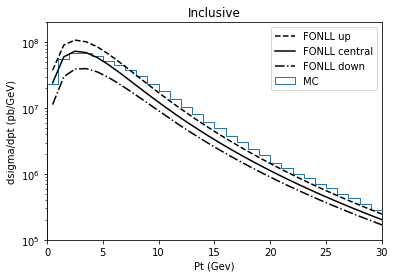

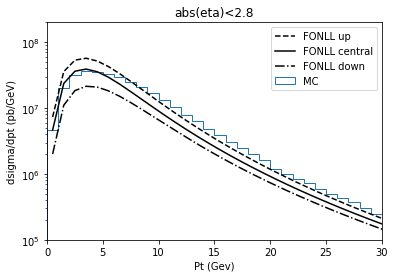

In [8]:
# Make a histograms out of the panda frame with the same binning
# normalizing the MC to FONLL central
tit = ('Inclusive', 'abs(eta)<2.8')
for qt, sig, dsdpt, b, t in zip([pt,pt28], [sigma,sigma*n28/n], [ds,ds28], [big,big28], tit):
    binsize = qt[1]-qt[0]
    temp = qt - binsize/2
    qtbins = np.append(temp, temp[-1]+binsize )
    ptMC = (b['bmesonpt']).to_numpy()
    w    = np.full(ptMC.shape[0], sig/(binsize * ptMC.shape[0]))
    ax = plt.subplot(111)
    h =ax.hist(ptMC, qtbins, histtype='step', label='MC', weights=w)
    ax.plot(qt, dsdpt[2],  linestyle='dashed', color='black',  label='FONLL up')
    ax.plot(qt, dsdpt[0],  linestyle='solid',  color='black', label='FONLL central')
    ax.plot(qt, dsdpt[1],  linestyle='dashdot',  color='black', label='FONLL down')
    ax.set_xlim(0,30)
    ax.set_ylim(1e5, 2e8)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel('Pt (Gev)')
    ax.set_ylabel('dsigma/dpt (pb/GeV)')
    ax.set_title(t)
    plt.show()
h_save = h    # Save the abs(eta)<2.8 results for later use

<ipython-input-9-c81a3b077971>:5: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(pt, ds28[2]/MC, linestyle='dashed', color='red', label='FONLL up/MC')
<ipython-input-9-c81a3b077971>:6: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(pt, ds28[0]/MC, linestyle='solid', color='black', label='FONLL central/MC')
<ipython-input-9-c81a3b077971>:7: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(pt, ds28[1]/MC, linestyle='dashdot', color='blue', label='FONLL down/MC')


Text(0.5, 1.0, 'abs(eta)<2.8')

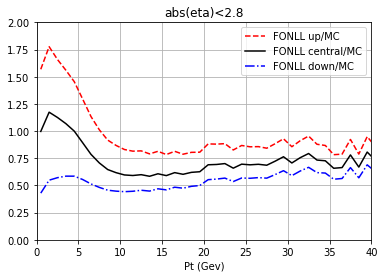

In [9]:
# Now plot ratio FONLL/MC fo abs(eta)<2.8
# We are going to re-use the "h_save" histogram that we made earlier
MC = h_save[0]
ax2 = plt.subplot(111)
ax2.plot(pt, ds28[2]/MC, linestyle='dashed', color='red', label='FONLL up/MC')
ax2.plot(pt, ds28[0]/MC, linestyle='solid', color='black', label='FONLL central/MC')
ax2.plot(pt, ds28[1]/MC, linestyle='dashdot', color='blue', label='FONLL down/MC')
ax2.set_xlim(0, 40.)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.set_xlabel('Pt (Gev)')
ax2.grid()
ax2.set_title('abs(eta)<2.8')

Text(0, 0.5, 'dsigma/deta (pb)')

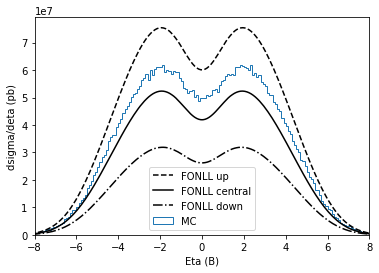

In [10]:
# Make also an eta plot just for fun
binsize = eta[1]-eta[0]
temp = eta - binsize/2
etabins = np.append(temp, temp[-1]+binsize )
etaMC = (big['bmesoneta']).to_numpy()
weta  = np.full(etaMC.shape[0], sigma/(binsize*etaMC.shape[0]))
ax3 = plt.subplot(111)
h_eta = ax3.hist(etaMC, etabins, histtype='step', label='MC', weights=weta)
ax3.plot(eta, dseta[2],      linestyle='dashed', color='black',  label='FONLL up')
ax3.plot(eta, dseta[0], linestyle='solid',  color='black', label='FONLL central')
ax3.plot(eta, dseta[1],    linestyle='dashdot',  color='black', label='FONLL down')
ax3.set_xlim(-8, 8.)
ax3.legend()
ax3.set_xlabel('Eta (B)')
ax3.set_ylabel('dsigma/deta (pb)')

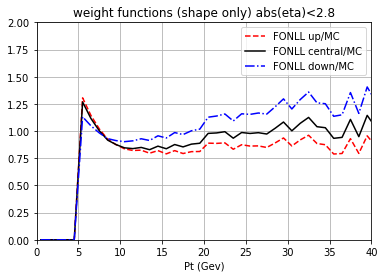

In [11]:
# Now we take the ratios that we just plotted and:
# (1) we impose pt > 5
# (2) we find rewighting factors "shape" only
# (3) we plot them as a sanity check
# (4) we write them out 
def safeDivision(n,d):
    if d == 0: return 0
    return float(n/d)
vSafeDivision = np.vectorize(safeDivision, otypes=[np.float64])

# remove bins with pt<5
MC_cut    = MC   * (pt28>5)
ds28_cut  = ds28 * (pt28>5)

# Find Pythia integral 
MCtot = MC_cut.sum()

# Get ratio (unnormalized)
ratio = vSafeDivision(ds28_cut, MC_cut)

# Reweight Pythia 
MC_cut_weighted = MC_cut * ratio
    
# Find the new integrals and the weight functions
# to reshape the the MC distributions
scale = []
w     = []
for m, r in zip(MC_cut_weighted,ratio):
    temp = MCtot/m.sum()
    scale.append(temp)
    w.append(temp*r)

# As a sanity check plot the w functions
ax3 = plt.subplot(111)
ax3.plot(pt, w[2], linestyle='dashed', color='red', label='FONLL up/MC')
ax3.plot(pt, w[0], linestyle='solid', color='black', label='FONLL central/MC')
ax3.plot(pt, w[1], linestyle='dashdot', color='blue', label='FONLL down/MC')
ax3.set_xlim(0, 40.)
ax3.set_ylim(0, 2)
ax3.legend()
ax3.set_xlabel('Pt (Gev)')
ax3.grid()
ax3.set_title('weight functions (shape only) abs(eta)<2.8')                


# write ratios to file
with open('results/weights_shapeOnly_2.8.txt', 'w') as f:
    f.write("# pt     central   down        up  \n")
    for a,b,c,d in zip(pt28,w[0],w[1],w[2]):
        f.write("%f %f %f %f \n" % (a, b, c, d))

In [12]:
# Now calculate the filter efficiency for pt>5 and abs(eta)<2.8 after reweighting the MC (shape only)
# Write it to the screen and to a file
with open('results/filter_efficiency_FONLL_shape.txt', 'w') as f1:
    dlist = list(dfs.values())
    for m,df in zip(dfs.keys(), dlist):
        
        # Get the pt's of the events into an array
        df0 = df.query("abs(bmesoneta)<2.8 & bmesonpt>5")
        df1 = df.query("abs(bmesoneta)<2.8 & bmesonpt>5 & mu2pt>3 & abs(mu2eta)<2.4 & abs(mu1eta)<2.4")
        pt0 = (df0['bmesonpt']).to_numpy()
        pt1 = (df1['bmesonpt']).to_numpy()

        # Get the pt's into histograms
        binsize = pt28[1]-pt28[0]
        temp    = pt28 - binsize/2
        ptbins  = np.append(temp, temp[-1]+binsize )
        h0,b    = np.histogram(pt0, ptbins)
        h1,b    = np.histogram(pt1, ptbins)
    
        # Reweight by the w functions, take the sum and the ratio
        print(' ')
        f1.write('\n')
        for ww, txt in zip(w, ['central', 'down   ', 'up     ']):
            n0 = (h0*ww).sum()
            n1 = (h1*ww).sum()
            eff = n1/n0
            deff = math.sqrt(eff*(1-eff)/n0)
            thisM = float(m.replace("p","."))
            print("Mass = {:.2f}".format(thisM), "GeV  FONLL ", txt," Filter eff = {:.2f}".format(100*eff), "+/- {:.2f}".format(100*deff), "%") 
            f1.write("Mass = {:.2f}".format(thisM) + " GeV  FONLL "+ txt + 
                     " Filter eff = {:.2f}".format(100*eff) + " +/- {:.2f}".format(100*deff) + " % \n") 


 
Mass = 0.30 GeV  FONLL  central  Filter eff = 11.69 +/- 0.25 %
Mass = 0.30 GeV  FONLL  down     Filter eff = 12.80 +/- 0.25 %
Mass = 0.30 GeV  FONLL  up       Filter eff = 11.15 +/- 0.24 %
 
Mass = 0.40 GeV  FONLL  central  Filter eff = 10.26 +/- 0.24 %
Mass = 0.40 GeV  FONLL  down     Filter eff = 11.23 +/- 0.25 %
Mass = 0.40 GeV  FONLL  up       Filter eff = 9.79 +/- 0.24 %
 
Mass = 0.50 GeV  FONLL  central  Filter eff = 8.95 +/- 0.22 %
Mass = 0.50 GeV  FONLL  down     Filter eff = 9.79 +/- 0.23 %
Mass = 0.50 GeV  FONLL  up       Filter eff = 8.55 +/- 0.21 %
 
Mass = 0.60 GeV  FONLL  central  Filter eff = 8.41 +/- 0.21 %
Mass = 0.60 GeV  FONLL  down     Filter eff = 9.22 +/- 0.22 %
Mass = 0.60 GeV  FONLL  up       Filter eff = 8.02 +/- 0.21 %
 
Mass = 0.75 GeV  FONLL  central  Filter eff = 8.33 +/- 0.21 %
Mass = 0.75 GeV  FONLL  down     Filter eff = 9.12 +/- 0.22 %
Mass = 0.75 GeV  FONLL  up       Filter eff = 7.95 +/- 0.21 %
 
Mass = 1.00 GeV  FONLL  central  Filter eff = 8.42 +/

In [13]:
# Now calculate the filter efficiency for pt>5 and abs(eta)<2.8 
# without reweighting, ie, assuming the Pythia shape.
# Write it ot a screen and to a file
with open('results/filter_efficiency_Pythia_shape.txt', 'w') as f2:
    dlist = list(dfs.values())
    for m,df in zip(dfs.keys(), dlist):
        n0 = sum((df['bmesonpt']>5) & (abs(df['bmesoneta'])<2.8))
        n1 = sum((df['bmesonpt']>5) & (abs(df['bmesoneta'])<2.8) & (df['mu2pt']>3) & 
             (abs(df['mu2eta'])<2.4) & (abs(df['mu1eta'])<2.4) )
        eff = n1/n0
        deff = math.sqrt(eff*(1-eff)/n0)
        thisM = float(m.replace("p","."))
        print("Mass = {:.2f}".format(thisM), "GeV  Pythia Filter eff = {:.2f}".format(100*eff), "+/- {:.2f}".format(100*deff), "%")
        f2.write("Mass = {:.2f}".format(thisM) + " GeV  Pythia Filter eff = {:.2f}".format(100*eff) + 
                 " +/- {:.2f}".format(100*deff) + " % \n")

Mass = 0.30 GeV  Pythia Filter eff = 12.97 +/- 0.26 %
Mass = 0.40 GeV  Pythia Filter eff = 11.31 +/- 0.26 %
Mass = 0.50 GeV  Pythia Filter eff = 9.95 +/- 0.23 %
Mass = 0.60 GeV  Pythia Filter eff = 9.31 +/- 0.22 %
Mass = 0.75 GeV  Pythia Filter eff = 9.22 +/- 0.22 %
Mass = 1.00 GeV  Pythia Filter eff = 9.27 +/- 0.22 %
Mass = 1.25 GeV  Pythia Filter eff = 9.63 +/- 0.24 %
Mass = 1.50 GeV  Pythia Filter eff = 9.78 +/- 0.23 %
Mass = 2.00 GeV  Pythia Filter eff = 10.27 +/- 0.23 %
Mass = 2.50 GeV  Pythia Filter eff = 11.07 +/- 0.24 %
Mass = 3.00 GeV  Pythia Filter eff = 13.12 +/- 0.26 %
Mass = 3.50 GeV  Pythia Filter eff = 14.78 +/- 0.27 %


In [14]:
# Sanity check on array multiplication
x = np.array([[10,20,30],[100,200,300]])
y = np.array([0.1, 0.2, 0.5])
x*y


array([[  1.,   4.,  15.],
       [ 10.,  40., 150.]])